# HumanEval Performance Analysis

This notebook analyzes the performance results from running HumanEval problems with and without monitoring.


In [10]:
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

# Load the results
results_file = Path('humaneval_performance_results.json')
if not results_file.exists():
    print("Results file not found. Make sure to run run.py first!")
else:
    with open(results_file, 'r') as f:
        results = json.load(f)
    print(f"Loaded {len(results)} results")


Loaded 164 results


In [11]:
# Process the results into a DataFrame
processed_data = []

for result in results:
    if 'error' in result:
        continue
    
    problem_idx = result['problem_index']
    
    # Reference data
    if 'reference' in result and 'error' not in result['reference']:
        ref_data = result['reference']
        processed_data.append({
            'problem_index': problem_idx,
            'version': 'reference',
            'wall_time': ref_data.get('wall_time', 0),
            'user_time': ref_data.get('user_time', 0),
            'system_time': ref_data.get('system_time', 0),
            'max_memory_kb': ref_data.get('max_memory_kb', 0),
            'success': ref_data.get('success', False),
            'db_size_bytes': 0  # No database for reference
        })
    
    # Monitored data
    if 'monitored' in result and 'error' not in result['monitored']:
        mon_data = result['monitored']
        processed_data.append({
            'problem_index': problem_idx,
            'version': 'monitored',
            'wall_time': mon_data.get('wall_time', 0),
            'user_time': mon_data.get('user_time', 0),
            'system_time': mon_data.get('system_time', 0),
            'max_memory_kb': mon_data.get('max_memory_kb', 0),
            'success': mon_data.get('success', False),
            'db_size_bytes': mon_data.get('db_size_bytes', 0)
        })

df = pd.DataFrame(processed_data)
print(f"Processed {len(df)} data points")
print(f"Success rate - Reference: {df[df['version'] == 'reference']['success'].mean():.2%}")
print(f"Success rate - Monitored: {df[df['version'] == 'monitored']['success'].mean():.2%}")

# Show basic statistics
df.groupby('version').agg({
    'wall_time': ['mean', 'median', 'std'],
    'max_memory_kb': ['mean', 'median', 'std'],
    'success': 'mean'
}).round(4)


Processed 328 data points
Success rate - Reference: 99.39%
Success rate - Monitored: 87.80%


wall_time                   max_memory_kb                      \
               mean  median       std          mean median          std   
version                                                                   
monitored  167.1112  22.534  295.4775    23661.1220    0.0  113140.1950   
reference    0.8165   0.339    2.6507     7311.9268    0.0   17573.1708   

          success  
             mean  
version            
monitored  0.8780  
reference  0.9939

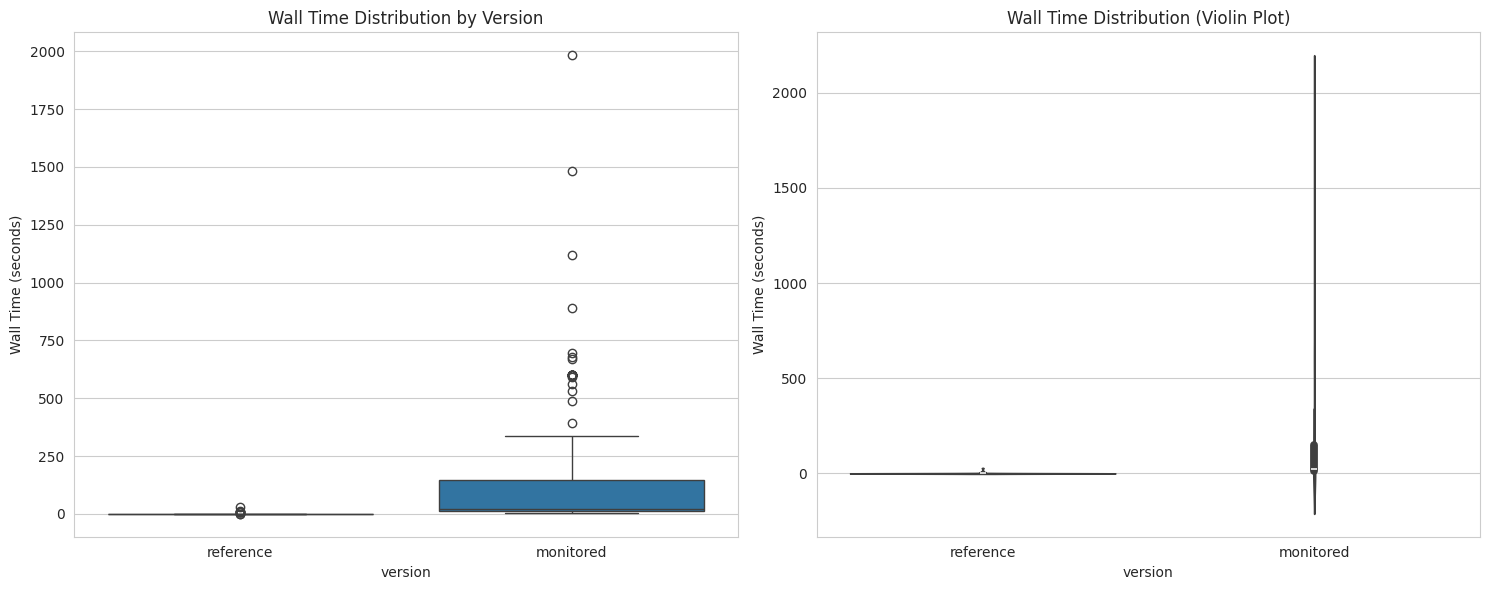

In [13]:
# Plot 1: Wall Time Comparison
plt.figure(figsize=(15, 6))

# Box plot
plt.subplot(1, 2, 1)
sns.boxplot(data=df, x='version', y='wall_time')
plt.title('Wall Time Distribution by Version')
plt.ylabel('Wall Time (seconds)')

# Violin plot
plt.subplot(1, 2, 2)
sns.violinplot(data=df, x='version', y='wall_time')
plt.title('Wall Time Distribution (Violin Plot)')
plt.ylabel('Wall Time (seconds)')

plt.tight_layout()
plt.show()


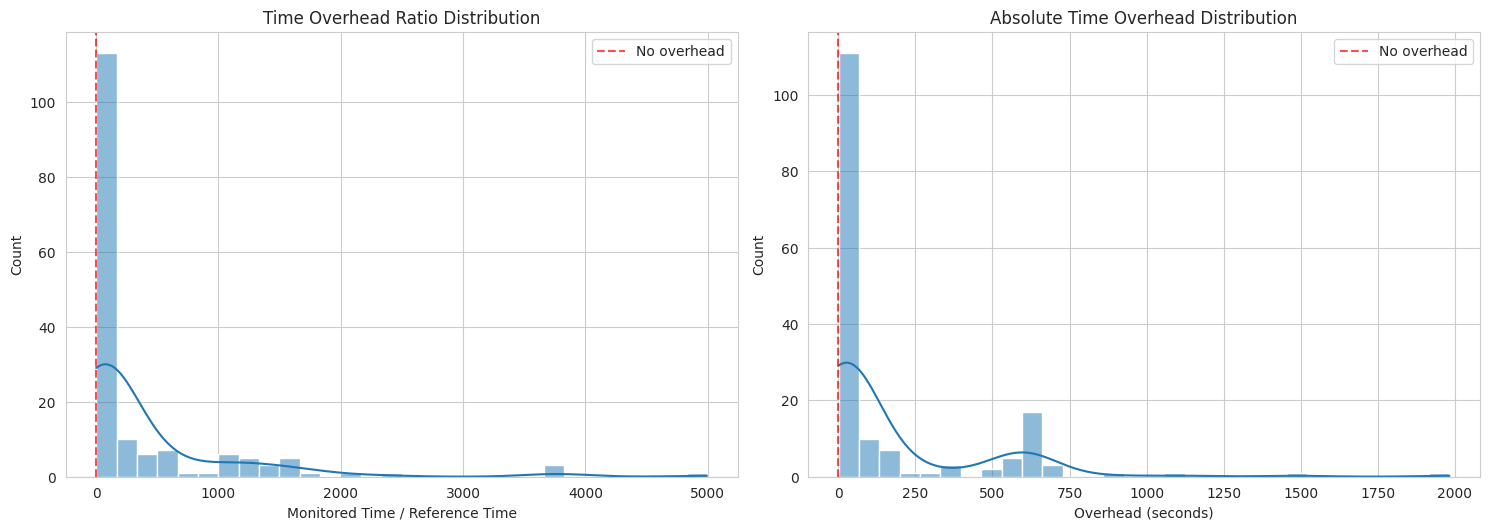

Mean overhead ratio: 385.49
Median overhead ratio: 63.61
Mean absolute overhead: 166.2946 seconds


In [15]:
# Plot 3: Performance Overhead Analysis
plt.figure(figsize=(15, 10))

# Calculate overhead for successful runs
pivot_time = df.pivot(index='problem_index', columns='version', values='wall_time')
pivot_time = pivot_time.dropna()
pivot_time['overhead_ratio'] = pivot_time['monitored'] / pivot_time['reference']
pivot_time['overhead_absolute'] = pivot_time['monitored'] - pivot_time['reference']

# Overhead ratio distribution
plt.subplot(2, 2, 1)
sns.histplot(pivot_time['overhead_ratio'], bins=30, kde=True)
plt.axvline(x=1, color='red', linestyle='--', alpha=0.7, label='No overhead')
plt.title('Time Overhead Ratio Distribution')
plt.xlabel('Monitored Time / Reference Time')
plt.legend()

# Absolute overhead
plt.subplot(2, 2, 2)
sns.histplot(pivot_time['overhead_absolute'], bins=30, kde=True)
plt.axvline(x=0, color='red', linestyle='--', alpha=0.7, label='No overhead')
plt.title('Absolute Time Overhead Distribution')
plt.xlabel('Overhead (seconds)')
plt.legend()


plt.tight_layout()
plt.show()

print(f"Mean overhead ratio: {pivot_time['overhead_ratio'].mean():.2f}")
print(f"Median overhead ratio: {pivot_time['overhead_ratio'].median():.2f}")
print(f"Mean absolute overhead: {pivot_time['overhead_absolute'].mean():.4f} seconds")


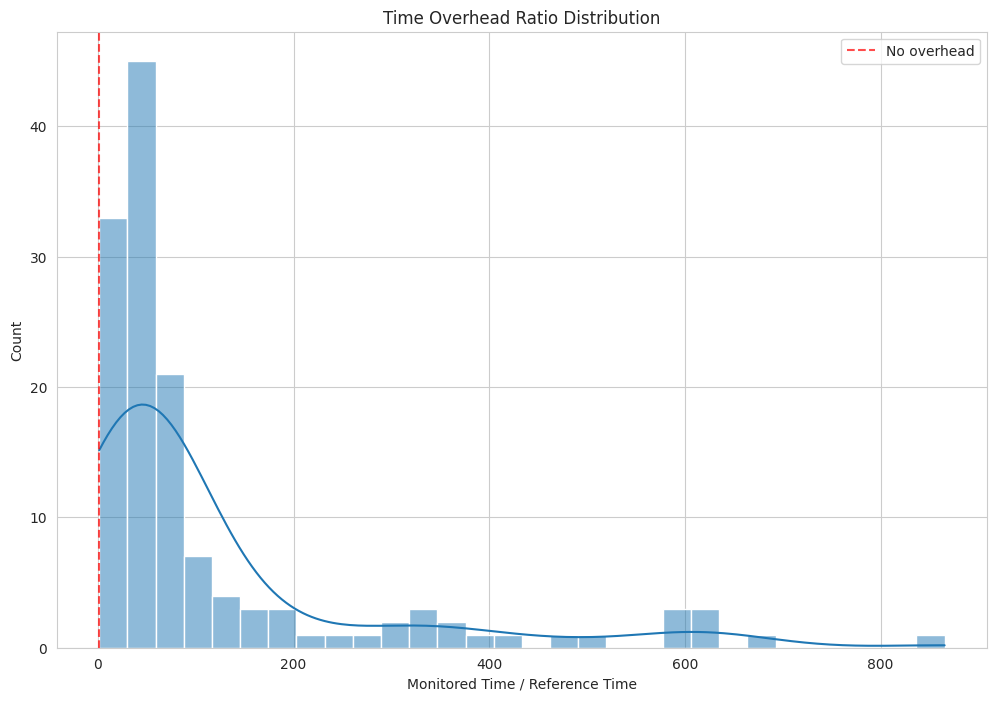

In [19]:
# Same as before, but remove outliers
# Calculate overhead for successful runs
pivot_time = df.pivot(index='problem_index', columns='version', values='wall_time')
pivot_time = pivot_time.dropna()
pivot_time['overhead_ratio'] = pivot_time['monitored'] / pivot_time['reference']

pivot_time = pivot_time[pivot_time['overhead_ratio'] < 1000]
sns.histplot(pivot_time['overhead_ratio'], bins=30, kde=True)
plt.axvline(x=1, color='red', linestyle='--', alpha=0.7, label='No overhead')
plt.title('Time Overhead Ratio Distribution')
plt.xlabel('Monitored Time / Reference Time')
plt.legend()


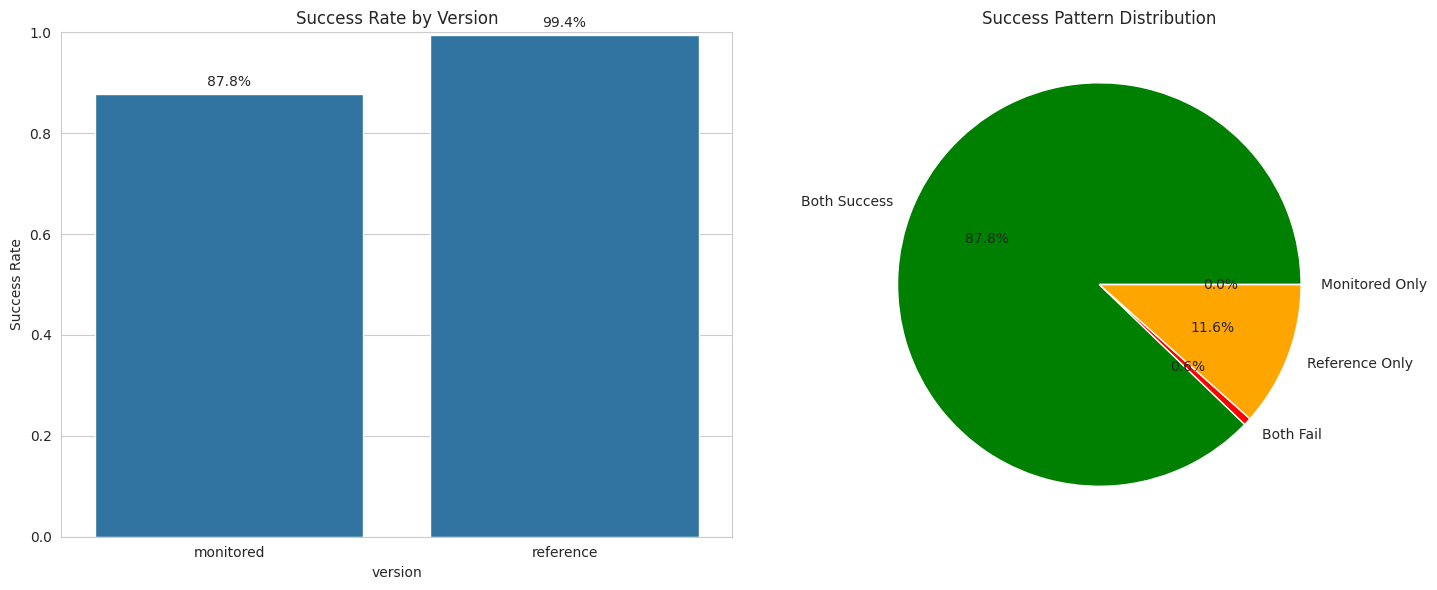

Problems where both succeeded: 144
Problems where both failed: 1
Problems where only reference succeeded: 19
Problems where only monitored succeeded: 0


In [16]:
# Plot 5: Success Rate Analysis
plt.figure(figsize=(15, 6))

# Success rate by version
plt.subplot(1, 2, 1)
success_rates = df.groupby('version')['success'].mean()
sns.barplot(x=success_rates.index, y=success_rates.values)
plt.title('Success Rate by Version')
plt.ylabel('Success Rate')
plt.ylim(0, 1)

# Add percentage labels
for i, v in enumerate(success_rates.values):
    plt.text(i, v + 0.01, f'{v:.1%}', ha='center', va='bottom')

# Problems with different outcomes
plt.subplot(1, 2, 2)
pivot_success = df.pivot(index='problem_index', columns='version', values='success')
pivot_success = pivot_success.dropna()

# Categorize outcomes
both_success = ((pivot_success['reference'] == True) & (pivot_success['monitored'] == True)).sum()
both_fail = ((pivot_success['reference'] == False) & (pivot_success['monitored'] == False)).sum()
ref_only = ((pivot_success['reference'] == True) & (pivot_success['monitored'] == False)).sum()
mon_only = ((pivot_success['reference'] == False) & (pivot_success['monitored'] == True)).sum()

categories = ['Both Success', 'Both Fail', 'Reference Only', 'Monitored Only']
counts = [both_success, both_fail, ref_only, mon_only]
colors = ['green', 'red', 'orange', 'blue']

plt.pie(counts, labels=categories, autopct='%1.1f%%', colors=colors)
plt.title('Success Pattern Distribution')

plt.tight_layout()
plt.show()

print(f"Problems where both succeeded: {both_success}")
print(f"Problems where both failed: {both_fail}")
print(f"Problems where only reference succeeded: {ref_only}")
print(f"Problems where only monitored succeeded: {mon_only}")
